In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model
import math
from sklearn.metrics import mean_squared_error
from google.colab import files, drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Ticker o ativo a ser utilizado
ticker = 'ABEV3'
 
#verificando se já existe o arquivo separado do ticker pedido
if not os.path.exists('/content/drive/MyDrive/Ia/%s.csv' %ticker):
  df = pd.read_csv('/content/drive/MyDrive/Ia/b3_stocks_1994_2020.csv')
    #econtrando e salvando o ativo especifico em outro arquivo
  df = df[df['ticker'] == ticker]
  df.to_csv('/content/drive/MyDrive/Ia/%s.csv'%ticker)
else:
  #caso arquivo foi criado anteriormente, só é feito a leitura dele
  df = pd.read_csv('/content/drive/MyDrive/Ia/%s.csv'%ticker)
  
#removendo todas colunas exceto a dos valores de fechamento 
df = df.drop(['ticker','datetime', 'volume', 'open', 'low', 'high'], axis=1)

In [ ]:
df

,close
0,17.40
1,17.06
2,17.03
3,17.47
4,17.65
...,...
1758,15.51
1759,15.50
1760,15.77
1761,15.95


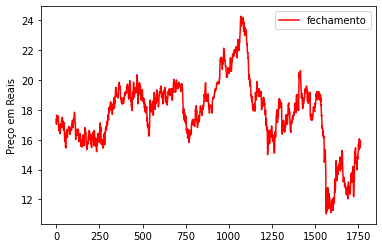

In [ ]:
plt.ylabel('Preço em Reais')
plt.plot(df, label='fechamento', c = 'r')
plt.legend()
plt.show()

In [ ]:
#Normalizando os dados para ficarem entre valores de -1 e 1
escala = MinMaxScaler(feature_range=(-1, 1))
df = np.array(df).reshape(-1,1)
df = escala.fit_transform(df)

#definindo tamanho dos nossos dados de treino 50% do nosso dataset
treino = df[0:int(len(df)*0.50)]

#num de valores que serao reservados para verificar 
#como a i.a se sai ao tentar prever valores fora do dataset
num_dias_para_comparar_com_previsao = 7

#definindo tamanho dos nossos time steps
time_step = 7;

x_treino = []
y_treino = []
x_teste = []
y_teste = []
x_validation = []
y_validation = []

#transformando os nossos dados em arrays que estão nos intervalos do tamanho do nosso time_step
for i in range(len(treino) - time_step):
    x_treino.append(treino[i:(i + time_step), 0:treino.shape[1]])
    y_treino.append(treino[i + time_step, 0])

#Separando dados para utilizar de validação
validation = df[int(len(x_treino)):int(len(df)*0.70)]

#transformando os nossos dados em arrays que estão nos intervalos do tamanho do nosso time_step
for j in range(len(validation) - time_step):
      x_validation.append(validation[j:(j + time_step), 0:validation.shape[1]])
      y_validation.append(validation[j + time_step, 0])   

#Separando dados para utilizar de teste
teste = df[len(x_treino)+len(x_validation):len(df)-num_dias_para_comparar_com_previsao]

#transformando os nossos dados em arrays que estão nos intervalos do tamanho do nosso time_step
for k in range(len(teste) - time_step):
      x_teste.append(teste[k:(k + time_step), 0:teste.shape[1]])
      y_teste.append(teste[k + time_step, 0])   

#transformando nossos em arrays do tipo numpy no formato samples,time step, features
x_treino,y_treino = np.array(x_treino), np.array(y_treino)
x_validation,y_validation = np.array(x_validation), np.array(y_validation)
x_teste,y_teste = np.array(x_teste), np.array(y_teste)

In [ ]:
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(x_treino.shape[1],x_treino.shape[2])))
model.add(LSTM(16,return_sequences=False))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='linear'))


model.compile(loss='mean_squared_error',optimizer='adam')

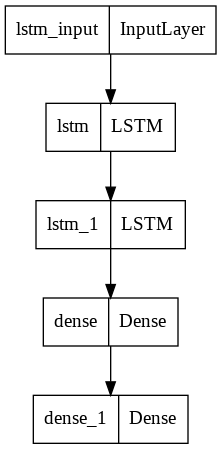

In [ ]:
plot_model(model)

In [ ]:
history = model.fit(x_treino,y_treino,validation_data=(x_validation,y_validation),epochs=50,batch_size=32,verbose=1)

Epoch 1/50
28/28 [==============================] - 9s 36ms/step - loss: 0.0243 - val_loss: 0.0770
Epoch 2/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0050 - val_loss: 0.0396
Epoch 3/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0304
Epoch 4/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0371
Epoch 5/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.0361
Epoch 6/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0364
Epoch 7/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0365
Epoch 8/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0334
Epoch 9/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0334
Epoch 10/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0343
Epoch 11/50
28/28 

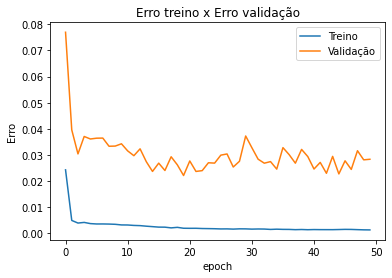

In [ ]:
plt.plot(history.history['loss'], label = 'Treino')
plt.plot(history.history['val_loss'], label = 'Validação')
plt.title('Erro treino x Erro validação')
plt.ylabel('Erro')
plt.xlabel('epoch')
plt.legend()
plt.show()


In [ ]:
#Passando os valores para i.a prever valores de y
teste_predict=model.predict(x_teste)
val_predict = model.predict(x_validation)
treino_predict=model.predict(x_treino)
#transformando os valores que estão entre -1 e 1 de volta para valores dos preços
treino_predict = escala.inverse_transform(treino_predict)
teste_predict = escala.inverse_transform(teste_predict)
val_predict = escala.inverse_transform(val_predict)

In [ ]:
aux1= y_treino.reshape(-1,1)
aux2= y_teste.reshape(-1,1)
aux3 = y_validation.reshape(-1,1)
#transformando os valores que estão entre -1 e 1 de volta para valores dos preços
aux1 = escala.inverse_transform(aux1)
aux2 = escala.inverse_transform(aux2)
aux3 = escala.inverse_transform(aux3)

#Calculando o erro entre o valor real e os previstos pela i.a
print("Erro treino :", math.sqrt(mean_squared_error(aux1,treino_predict)))
print("Erro validacao :", math.sqrt(mean_squared_error(aux3,val_predict)))
print("Erro teste :", math.sqrt(mean_squared_error(aux2,teste_predict)))

Erro treino : 0.03625821407947031
Erro validacao : 0.16844852133662638
Erro teste : 0.13254015616185172


In [ ]:
#transformando o dataframe de volta para os valores de preço
df = escala.inverse_transform(df)
#Refazendo o shape do modelo de maneira que todos valores fiquem em apenas uma coluna
dfn = df.reshape(-1,1)

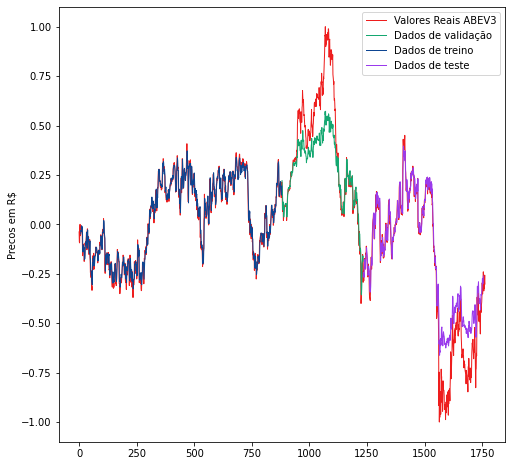

In [ ]:


#Treino plot é agora um array vazio com o mesmo formato do array do dataframe original
treinoPlot = np.empty_like(dfn)
#Todos valores do array são preenchido com Nan values, ou seja, valores nulos que não aparacetão no plot
treinoPlot[:] = np.nan
#Agora todos valores no intervalo do primeiro time_step, 
#que corresponde a primeira previsao, até o a ultima previsão são preenchidos com os valores do predict do nosso modelo
treinoPlot[time_step:len(x_treino)+time_step] = treino_predict

#isso é feito de maneira analoga para todos arrays
valPlot = np.empty_like(dfn)
valPlot[:] = np.nan
valPlot[len(x_treino)+time_step:len(x_treino)+len(x_validation)+time_step] = val_predict

testePlot = np.empty_like(dfn)
testePlot[:] = np.nan
testePlot[len(x_treino)+len(x_validation)+time_step:len(dfn)-num_dias_para_comparar_com_previsao] = teste_predict

f, ax = plt.subplots()

plt.gcf().set_size_inches(8, 8, forward=True)
plt.ylabel('Precos em R$')
ax.locator_params(axis='x', nbins = 8)
ax.plot(dfn, label = 'Valores Reais %s' %ticker, c ='#ee1d1d', linewidth=1)
ax.plot(valPlot, label = 'Dados de validação', c = '#14a770', linewidth=1)
ax.plot(treinoPlot, label = 'Dados de treino', c = '#0d4592', linewidth=1)
ax.plot(testePlot, label = 'Dados de teste', c = '#9a3aec', linewidth=1)
ax.legend()
plt.show()

In [ ]:
#criando um arra com o último time step do nossos valores de tsete
previsao = teste[-time_step:]
previsao = previsao.reshape(1,-1)

#lista que será auxiliar para guardar valores durante a interção
aux = list(previsao)
aux = previsao[0].tolist()

#lista que terá os valores previstos
resultado = []
dias_previsao = 7
a = 0
for a in range(dias_previsao):   

    #Proximas interações
    if(len(aux)>time_step):
        #desconsiderando primeiro valor do array,pois o array tem time step+1 e 
        #o aux é passado para previsao que sera o input do modelo
        previsao=np.array(aux[1:])
        previsao = previsao.reshape((1,time_step, 1))
        preco_previsto = model.predict(previsao)
        #valor previsto é adicionado ao aux e desconsideramos o primeiro numero novamente
        aux.extend(preco_previsto[0].tolist())
        aux=aux[1:]
        #resultado recebe os valore previstos
        resultado.extend(preco_previsto.tolist())
    #Caso for a primeira interção, aux vai prever o proximo valor
    #e adicionará ao final do array e da lista de previsao
    else:
        previsao = previsao.reshape((1, time_step,1))
        preco_previsto = model.predict(previsao)
        aux.extend(preco_previsto[0].tolist())
        resultado.extend(preco_previsto.tolist())
    


In [ ]:
resultado = escala.inverse_transform(resultado)
teste_predict_maisfuturo = np.concatenate([teste_predict,resultado])

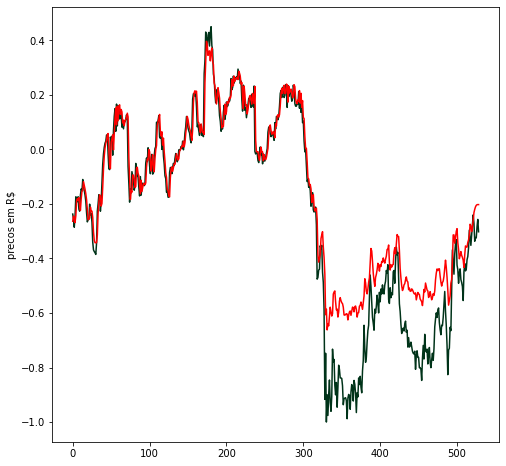

In [ ]:
plt.gcf().set_size_inches(8, 8, forward=True)
plt.ylabel('precos em R$')
plt.plot(dfn[len(x_treino)+len(x_validation)+(time_step):],c = '#003319', label = 'Real')
plt.plot(teste_predict_maisfuturo, c ='r', label = 'Teste+previsao')
plt.show()

In [ ]:
a = resultado
print(a)

[[-0.23201489]
 [-0.2199256 ]
 [-0.21079078]
 [-0.20524973]
 [-0.20285098]
 [-0.20235625]
 [-0.20241641]]


In [ ]:
print(df[len(dfn)-num_dias_para_comparar_com_previsao:])

[[-0.27039275]
 [-0.33685801]
 [-0.32326284]
 [-0.32477341]
 [-0.28398792]
 [-0.25679758]
 [-0.3021148 ]]


In [ ]:
print("Erro previsao futuro :", math.sqrt(mean_squared_error(resultado,
df[len(dfn)-num_dias_para_comparar_com_previsao:])))

Erro previsao futuro : 0.09378452100844659


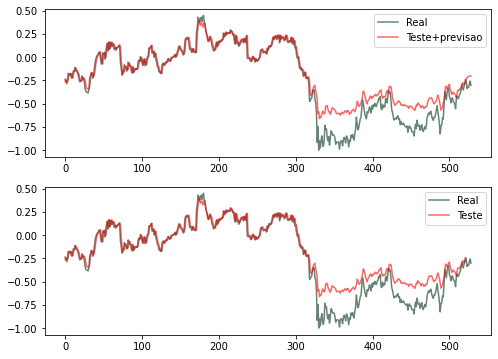

In [ ]:
fig, ax = plt.subplots(2, figsize=(8, 6))
ax[0].plot(dfn[len(x_treino)+len(x_validation)+(time_step):],c = '#003319', label = 'Real', alpha = 0.6)
ax[0].plot(teste_predict_maisfuturo,c = 'r', label = 'Teste+previsao', alpha= 0.6)
ax[1].plot(dfn[len(x_treino)+len(x_validation)+(time_step):],c = '#003319', label = 'Real', alpha = 0.6)
ax[1].plot(teste_predict,c = 'r', label = 'Teste', alpha = 0.6)
ax[0].legend()
ax[1].legend()
plt.show()

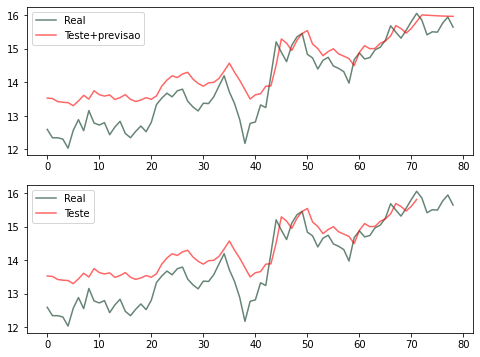

In [ ]:
fig, ax = plt.subplots(2, figsize=(8, 6))
ax[0].plot(dfn[len(x_treino)+len(x_validation)+(time_step)+450:],c = '#003319', label = 'Real', alpha = 0.6)
ax[0].plot(teste_predict_maisfuturo[450:],c = 'r', label = 'Teste+previsao', alpha= 0.6)
ax[1].plot(dfn[len(x_treino)+len(x_validation)+(time_step)+450:],c = '#003319', label = 'Real', alpha = 0.6)
ax[1].plot(teste_predict[450:],c = 'r', label = 'Teste', alpha = 0.6)
ax[0].legend()
ax[1].legend()
plt.show()